# Afriat

In [1]:
ood_seed = 16

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('30', 'Periportal', 'Uninfected')


Removed datapoint: 963

train         14370
validation     3720
ood             963
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 52%|█████▏    | 9911/19053 [00:00<00:00, 99098.75it/s]

100%|██████████| 19053/19053 [00:00<00:00, 95010.25it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1140212.51it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 288.43it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:08<58:59,  8.87s/it]

Epoch 1/400:   0%|          | 1/400 [00:08<58:59,  8.87s/it, v_num=1, recon=3.99e+3, r2_mean=0.193, adv_loss=3.32, acc_pert=0.259, acc_zone=0.723, acc_status_control=0.475]

Epoch 2/400:   0%|          | 1/400 [00:08<58:59,  8.87s/it, v_num=1, recon=3.99e+3, r2_mean=0.193, adv_loss=3.32, acc_pert=0.259, acc_zone=0.723, acc_status_control=0.475]

Epoch 2/400:   0%|          | 2/400 [00:17<57:25,  8.66s/it, v_num=1, recon=3.99e+3, r2_mean=0.193, adv_loss=3.32, acc_pert=0.259, acc_zone=0.723, acc_status_control=0.475]

Epoch 2/400:   0%|          | 2/400 [00:17<57:25,  8.66s/it, v_num=1, recon=3.26e+3, r2_mean=0.604, adv_loss=2.85, acc_pert=0.393, acc_zone=0.818, acc_status_control=0.601]

Epoch 3/400:   0%|          | 2/400 [00:17<57:25,  8.66s/it, v_num=1, recon=3.26e+3, r2_mean=0.604, adv_loss=2.85, acc_pert=0.393, acc_zone=0.818, acc_status_control=0.601]

Epoch 3/400:   1%|          | 3/400 [00:25<56:49,  8.59s/it, v_num=1, recon=3.26e+3, r2_mean=0.604, adv_loss=2.85, acc_pert=0.393, acc_zone=0.818, acc_status_control=0.601]

Epoch 3/400:   1%|          | 3/400 [00:25<56:49,  8.59s/it, v_num=1, recon=3.2e+3, r2_mean=0.706, adv_loss=2.76, acc_pert=0.405, acc_zone=0.823, acc_status_control=0.606] 

Epoch 4/400:   1%|          | 3/400 [00:25<56:49,  8.59s/it, v_num=1, recon=3.2e+3, r2_mean=0.706, adv_loss=2.76, acc_pert=0.405, acc_zone=0.823, acc_status_control=0.606]

Epoch 4/400:   1%|          | 4/400 [00:34<56:42,  8.59s/it, v_num=1, recon=3.2e+3, r2_mean=0.706, adv_loss=2.76, acc_pert=0.405, acc_zone=0.823, acc_status_control=0.606]

Epoch 4/400:   1%|          | 4/400 [00:34<56:42,  8.59s/it, v_num=1, recon=3.18e+3, r2_mean=0.747, adv_loss=2.74, acc_pert=0.43, acc_zone=0.834, acc_status_control=0.599]

Epoch 5/400:   1%|          | 4/400 [00:34<56:42,  8.59s/it, v_num=1, recon=3.18e+3, r2_mean=0.747, adv_loss=2.74, acc_pert=0.43, acc_zone=0.834, acc_status_control=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:43<56:29,  8.58s/it, v_num=1, recon=3.18e+3, r2_mean=0.747, adv_loss=2.74, acc_pert=0.43, acc_zone=0.834, acc_status_control=0.599]

Epoch 5/400:   1%|▏         | 5/400 [00:43<56:29,  8.58s/it, v_num=1, recon=3.17e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.516, acc_zone=0.836, acc_status_control=0.6]  

Epoch 6/400:   1%|▏         | 5/400 [00:43<56:29,  8.58s/it, v_num=1, recon=3.17e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.516, acc_zone=0.836, acc_status_control=0.6]

Epoch 6/400:   2%|▏         | 6/400 [00:51<56:19,  8.58s/it, v_num=1, recon=3.17e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.516, acc_zone=0.836, acc_status_control=0.6]

Epoch 6/400:   2%|▏         | 6/400 [00:51<56:19,  8.58s/it, v_num=1, recon=3.16e+3, r2_mean=0.783, adv_loss=2.3, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.606]

Epoch 7/400:   2%|▏         | 6/400 [00:51<56:19,  8.58s/it, v_num=1, recon=3.16e+3, r2_mean=0.783, adv_loss=2.3, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.606]

Epoch 7/400:   2%|▏         | 7/400 [01:00<56:09,  8.57s/it, v_num=1, recon=3.16e+3, r2_mean=0.783, adv_loss=2.3, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.606]

Epoch 7/400:   2%|▏         | 7/400 [01:00<56:09,  8.57s/it, v_num=1, recon=3.15e+3, r2_mean=0.796, adv_loss=2.19, acc_pert=0.614, acc_zone=0.848, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 7/400 [01:00<56:09,  8.57s/it, v_num=1, recon=3.15e+3, r2_mean=0.796, adv_loss=2.19, acc_pert=0.614, acc_zone=0.848, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 8/400 [01:08<55:54,  8.56s/it, v_num=1, recon=3.15e+3, r2_mean=0.796, adv_loss=2.19, acc_pert=0.614, acc_zone=0.848, acc_status_control=0.615]

Epoch 8/400:   2%|▏         | 8/400 [01:08<55:54,  8.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.616]

Epoch 9/400:   2%|▏         | 8/400 [01:08<55:54,  8.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.616]

Epoch 9/400:   2%|▏         | 9/400 [01:17<55:44,  8.55s/it, v_num=1, recon=3.14e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.616]

Epoch 9/400:   2%|▏         | 9/400 [01:17<55:44,  8.55s/it, v_num=1, recon=3.14e+3, r2_mean=0.807, adv_loss=2.11, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.613]

Epoch 10/400:   2%|▏         | 9/400 [01:17<55:44,  8.55s/it, v_num=1, recon=3.14e+3, r2_mean=0.807, adv_loss=2.11, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.613]


disnt_basal = 1.2496700985529943

disnt_after = 1.8979903203414508

val_r2_mean = 0.8055199026209003

val_r2_var = 0.16970587416008515


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:30<1:04:44,  9.96s/it, v_num=1, recon=3.14e+3, r2_mean=0.807, adv_loss=2.11, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.613]

Epoch 10/400:   2%|▎         | 10/400 [01:30<1:04:44,  9.96s/it, v_num=1, recon=3.13e+3, r2_mean=0.809, adv_loss=2.08, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.62, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:30<1:04:44,  9.96s/it, v_num=1, recon=3.13e+3, r2_mean=0.809, adv_loss=2.08, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.62, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:38<1:01:52,  9.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.809, adv_loss=2.08, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.62, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:38<1:01:52,  9.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.814, adv_loss=2.06, acc_pert=0.658, acc_zone=0.854, acc_status_control=0.615, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:38<1:01:52,  9.54s/it, v_num=1, recon=3.13e+3, r2_mean=0.814, adv_loss=2.06, acc_pert=0.658, acc_zone=0.854, acc_status_control=0.615, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:47<59:52,  9.26s/it, v_num=1, recon=3.13e+3, r2_mean=0.814, adv_loss=2.06, acc_pert=0.658, acc_zone=0.854, acc_status_control=0.615, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]  

Epoch 12/400:   3%|▎         | 12/400 [01:47<59:52,  9.26s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.665, acc_zone=0.852, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:47<59:52,  9.26s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.665, acc_zone=0.852, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:56<58:26,  9.06s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.02, acc_pert=0.665, acc_zone=0.852, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:56<58:26,  9.06s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=1.99, acc_pert=0.673, acc_zone=0.851, acc_status_control=0.626, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [01:56<58:26,  9.06s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=1.99, acc_pert=0.673, acc_zone=0.851, acc_status_control=0.626, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:04<57:23,  8.92s/it, v_num=1, recon=3.11e+3, r2_mean=0.813, adv_loss=1.99, acc_pert=0.673, acc_zone=0.851, acc_status_control=0.626, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:04<57:23,  8.92s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.678, acc_zone=0.856, acc_status_control=0.627, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:04<57:23,  8.92s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.678, acc_zone=0.856, acc_status_control=0.627, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:13<56:28,  8.80s/it, v_num=1, recon=3.11e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.678, acc_zone=0.856, acc_status_control=0.627, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:13<56:28,  8.80s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.99, acc_pert=0.677, acc_zone=0.856, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:13<56:28,  8.80s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.99, acc_pert=0.677, acc_zone=0.856, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:21<55:51,  8.73s/it, v_num=1, recon=3.1e+3, r2_mean=0.816, adv_loss=1.99, acc_pert=0.677, acc_zone=0.856, acc_status_control=0.623, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:21<55:51,  8.73s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.97, acc_pert=0.678, acc_zone=0.854, acc_status_control=0.63, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [02:21<55:51,  8.73s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.97, acc_pert=0.678, acc_zone=0.854, acc_status_control=0.63, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:30<55:12,  8.65s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.97, acc_pert=0.678, acc_zone=0.854, acc_status_control=0.63, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:30<55:12,  8.65s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.96, acc_pert=0.684, acc_zone=0.851, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:30<55:12,  8.65s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.96, acc_pert=0.684, acc_zone=0.851, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:38<54:48,  8.61s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.96, acc_pert=0.684, acc_zone=0.851, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:38<54:48,  8.61s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.98, acc_pert=0.677, acc_zone=0.853, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:38<54:48,  8.61s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.98, acc_pert=0.677, acc_zone=0.853, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:47<54:33,  8.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.821, adv_loss=1.98, acc_pert=0.677, acc_zone=0.853, acc_status_control=0.628, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:47<54:33,  8.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:47<54:33,  8.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]


disnt_basal = 1.2515283834344062

disnt_after = 1.8816862398325973

val_r2_mean = 0.8200183918277092

val_r2_var = 0.20908102019695943

Epoch 20/400:   5%|▌         | 20/400 [03:00<1:03:17,  9.99s/it, v_num=1, recon=3.09e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.635, val_recon=3.13e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.806, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:00<1:03:17,  9.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.68, acc_zone=0.853, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [03:00<1:03:17,  9.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.68, acc_zone=0.853, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:09<1:00:18,  9.55s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.68, acc_zone=0.853, acc_status_control=0.637, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:09<1:00:18,  9.55s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.672, acc_zone=0.851, acc_status_control=0.631, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:09<1:00:18,  9.55s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.672, acc_zone=0.851, acc_status_control=0.631, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:17<58:17,  9.25s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.96, acc_pert=0.672, acc_zone=0.851, acc_status_control=0.631, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]  

Epoch 22/400:   6%|▌         | 22/400 [03:17<58:17,  9.25s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [03:17<58:17,  9.25s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:26<56:45,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:26<56:45,  9.03s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.673, acc_zone=0.853, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:26<56:45,  9.03s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.673, acc_zone=0.853, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:34<55:38,  8.88s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.95, acc_pert=0.673, acc_zone=0.853, acc_status_control=0.636, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:34<55:38,  8.88s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.643, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [03:34<55:38,  8.88s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.643, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:43<54:48,  8.77s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.94, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.643, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:43<54:48,  8.77s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.676, acc_zone=0.854, acc_status_control=0.635, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:43<54:48,  8.77s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.676, acc_zone=0.854, acc_status_control=0.635, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:51<54:13,  8.70s/it, v_num=1, recon=3.07e+3, r2_mean=0.825, adv_loss=1.97, acc_pert=0.676, acc_zone=0.854, acc_status_control=0.635, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:51<54:13,  8.70s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]  

Epoch 27/400:   6%|▋         | 26/400 [03:51<54:13,  8.70s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:00<53:53,  8.67s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:00<53:53,  8.67s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.645, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:00<53:53,  8.67s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.645, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:08<53:32,  8.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.827, adv_loss=1.96, acc_pert=0.674, acc_zone=0.851, acc_status_control=0.645, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:08<53:32,  8.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:08<53:32,  8.63s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:17<53:09,  8.60s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=1.98, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.644, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:17<53:09,  8.60s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [04:17<53:09,  8.60s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]


disnt_basal = 1.2411433678697519

disnt_after = 1.8764916272144256

val_r2_mean = 0.8186025422599342

val_r2_var = 0.226169717315213


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [04:30<1:01:48, 10.02s/it, v_num=1, recon=3.05e+3, r2_mean=0.827, adv_loss=2.01, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.64, val_recon=3.1e+3, disnt_basal=1.25, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:30<1:01:48, 10.02s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.672, acc_zone=0.848, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:30<1:01:48, 10.02s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.672, acc_zone=0.848, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:39<58:59,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=1.99, acc_pert=0.672, acc_zone=0.848, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]  

Epoch 31/400:   8%|▊         | 31/400 [04:39<58:59,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]    

Epoch 32/400:   8%|▊         | 31/400 [04:39<58:59,  9.59s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:47<56:58,  9.29s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2, acc_pert=0.66, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:47<56:58,  9.29s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.01, acc_pert=0.658, acc_zone=0.85, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:48<56:58,  9.29s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.01, acc_pert=0.658, acc_zone=0.85, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:56<55:47,  9.12s/it, v_num=1, recon=3.05e+3, r2_mean=0.828, adv_loss=2.01, acc_pert=0.658, acc_zone=0.85, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [04:56<55:47,  9.12s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.658, acc_zone=0.849, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [04:56<55:47,  9.12s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.658, acc_zone=0.849, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:05<54:42,  8.97s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.02, acc_pert=0.658, acc_zone=0.849, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:05<54:42,  8.97s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.648, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:05<54:42,  8.97s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.648, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:14<54:07,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.648, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:14<54:07,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:14<54:07,  8.90s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:22<53:23,  8.80s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.646, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:22<53:23,  8.80s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:22<53:23,  8.80s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:31<52:58,  8.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=2.05, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:31<52:58,  8.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [05:31<52:58,  8.76s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:39<52:31,  8.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:39<52:31,  8.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.06, acc_pert=0.647, acc_zone=0.848, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:39<52:31,  8.71s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.06, acc_pert=0.647, acc_zone=0.848, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:48<52:12,  8.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.06, acc_pert=0.647, acc_zone=0.848, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:48<52:12,  8.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.07, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [05:48<52:12,  8.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.07, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.2348861656931847

disnt_after = 1.866521974099199

val_r2_mean = 0.8204229614156909

val_r2_var = 0.24087499642050617


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:01<1:00:23, 10.07s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=2.07, acc_pert=0.645, acc_zone=0.849, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.24, disnt_after=1.88, val_r2_mean=0.819, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:01<1:00:23, 10.07s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.08, acc_pert=0.636, acc_zone=0.849, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [06:01<1:00:23, 10.07s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.08, acc_pert=0.636, acc_zone=0.849, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:10<57:26,  9.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.08, acc_pert=0.636, acc_zone=0.849, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [06:10<57:26,  9.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.1, acc_pert=0.635, acc_zone=0.847, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [06:10<57:26,  9.60s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.1, acc_pert=0.635, acc_zone=0.847, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:18<55:22,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=2.1, acc_pert=0.635, acc_zone=0.847, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:18<55:22,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.11, acc_pert=0.638, acc_zone=0.844, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:18<55:22,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.11, acc_pert=0.638, acc_zone=0.844, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:27<53:55,  9.06s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=2.11, acc_pert=0.638, acc_zone=0.844, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:27<53:55,  9.06s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.625, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [06:27<53:55,  9.06s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.625, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:35<52:55,  8.92s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.625, acc_zone=0.849, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:35<52:55,  8.92s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.621, acc_zone=0.844, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan] 

Epoch 45/400:  11%|█         | 44/400 [06:35<52:55,  8.92s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.621, acc_zone=0.844, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:44<51:58,  8.79s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.621, acc_zone=0.844, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:44<51:58,  8.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.619, acc_zone=0.847, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [06:44<51:58,  8.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.619, acc_zone=0.847, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:52<51:23,  8.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.14, acc_pert=0.619, acc_zone=0.847, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [06:52<51:23,  8.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.617, acc_zone=0.846, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [06:52<51:23,  8.71s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.617, acc_zone=0.846, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:01<50:55,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=2.14, acc_pert=0.617, acc_zone=0.846, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:01<50:55,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:01<50:55,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:10<51:13,  8.73s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=2.16, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:10<51:13,  8.73s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.611, acc_zone=0.843, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:10<51:13,  8.73s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.611, acc_zone=0.843, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:18<50:38,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.832, adv_loss=2.16, acc_pert=0.611, acc_zone=0.843, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:18<50:38,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.612, acc_zone=0.845, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [07:18<50:38,  8.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.612, acc_zone=0.845, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]


disnt_basal = 1.2256553127690106

disnt_after = 1.8743387060408658

val_r2_mean = 0.8224322640425038

val_r2_var = 0.24359341736400533


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [07:32<58:36, 10.05s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.612, acc_zone=0.845, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.82, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:32<58:36, 10.05s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.843, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [07:32<58:36, 10.05s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.843, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:40<55:52,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.17, acc_pert=0.608, acc_zone=0.843, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:40<55:52,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:40<55:52,  9.60s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:49<53:58,  9.31s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.18, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:49<53:58,  9.31s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.604, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [07:49<53:58,  9.31s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.604, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:57<52:21,  9.05s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.19, acc_pert=0.604, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [07:57<52:21,  9.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.596, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [07:57<52:21,  9.05s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.596, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:06<51:06,  8.86s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.596, acc_zone=0.843, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:06<51:06,  8.86s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.598, acc_zone=0.844, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]    

Epoch 55/400:  14%|█▎        | 54/400 [08:06<51:06,  8.86s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.598, acc_zone=0.844, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:14<50:37,  8.80s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=2.2, acc_pert=0.598, acc_zone=0.844, acc_status_control=0.645, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:14<50:37,  8.80s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:14<50:37,  8.80s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:23<50:01,  8.72s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.2, acc_pert=0.597, acc_zone=0.842, acc_status_control=0.642, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:23<50:01,  8.72s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [08:23<50:01,  8.72s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:31<49:26,  8.65s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.602, acc_zone=0.841, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:31<49:26,  8.65s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.21, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [08:31<49:26,  8.65s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.21, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:40<48:59,  8.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.21, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:40<48:59,  8.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:40<48:59,  8.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:48<48:41,  8.57s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=2.19, acc_pert=0.593, acc_zone=0.844, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:48<48:41,  8.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.592, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan] 

Epoch 60/400:  15%|█▍        | 59/400 [08:48<48:41,  8.57s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.592, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.2121029856266565

disnt_after = 1.859402665686625

val_r2_mean = 0.8262821894221932

val_r2_var = 0.25447495985443547


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:02<56:31,  9.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.592, acc_zone=0.84, acc_status_control=0.646, val_recon=2.99e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.822, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:02<56:31,  9.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:02<56:31,  9.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:10<53:53,  9.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.594, acc_zone=0.835, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:10<53:53,  9.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:10<53:53,  9.54s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:19<51:58,  9.23s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.586, acc_zone=0.839, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:19<51:58,  9.23s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [09:19<51:58,  9.23s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:27<50:27,  8.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=2.24, acc_pert=0.587, acc_zone=0.837, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:27<50:27,  8.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.23, acc_pert=0.587, acc_zone=0.843, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [09:27<50:27,  8.98s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.23, acc_pert=0.587, acc_zone=0.843, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:36<49:28,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.23, acc_pert=0.587, acc_zone=0.843, acc_status_control=0.639, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:36<49:28,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [09:36<49:28,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:44<48:41,  8.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.23, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:44<48:41,  8.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [09:44<48:41,  8.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:53<48:13,  8.66s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.23, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [09:53<48:13,  8.66s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.24, acc_pert=0.585, acc_zone=0.839, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [09:53<48:13,  8.66s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.24, acc_pert=0.585, acc_zone=0.839, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:01<47:40,  8.59s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.24, acc_pert=0.585, acc_zone=0.839, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:01<47:40,  8.59s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:01<47:40,  8.59s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:10<47:29,  8.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.23, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.641, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:10<47:29,  8.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [10:10<47:29,  8.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:18<47:32,  8.62s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.635, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:18<47:32,  8.62s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 70/400:  17%|█▋        | 69/400 [10:18<47:32,  8.62s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2433428001363789

disnt_after = 1.8961567083071944

val_r2_mean = 0.8213098640313755

val_r2_var = 0.24346669218046227


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [10:32<55:07, 10.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.64, val_recon=3.01e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:32<55:07, 10.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]   

Epoch 71/400:  18%|█▊        | 70/400 [10:32<55:07, 10.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:40<52:30,  9.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.25, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:40<52:30,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [10:40<52:30,  9.58s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:49<50:36,  9.26s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.25, acc_pert=0.582, acc_zone=0.844, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [10:49<50:36,  9.26s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [10:49<50:36,  9.26s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:57<49:11,  9.03s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.25, acc_pert=0.588, acc_zone=0.842, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [10:57<49:11,  9.03s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [10:57<49:11,  9.03s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:06<48:12,  8.87s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.579, acc_zone=0.837, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:06<48:12,  8.87s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:06<48:12,  8.87s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:14<47:25,  8.76s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=2.25, acc_pert=0.582, acc_zone=0.837, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:14<47:25,  8.76s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [11:14<47:25,  8.76s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:23<46:59,  8.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:23<46:59,  8.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [11:23<46:59,  8.70s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:31<46:36,  8.66s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.25, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:31<46:36,  8.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.26, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan] 

Epoch 78/400:  19%|█▉        | 77/400 [11:31<46:36,  8.66s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.26, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:40<46:02,  8.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.26, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:40<46:02,  8.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [11:40<46:02,  8.58s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [11:48<45:46,  8.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.57, acc_zone=0.839, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [11:48<45:46,  8.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [11:48<45:46,  8.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.2158157433457752

disnt_after = 1.8684607868672118

val_r2_mean = 0.8271370900986104

val_r2_var = 0.24202332512367072


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [12:01<53:14,  9.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.575, acc_zone=0.838, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.24, disnt_after=1.9, val_r2_mean=0.821, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:01<53:14,  9.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:01<53:14,  9.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:10<51:19,  9.65s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=2.26, acc_pert=0.577, acc_zone=0.836, acc_status_control=0.64, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:10<51:19,  9.65s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [12:10<51:19,  9.65s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:19<49:24,  9.32s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.27, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:19<49:24,  9.32s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [12:19<49:24,  9.32s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:27<47:59,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.26, acc_pert=0.574, acc_zone=0.837, acc_status_control=0.641, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:27<47:59,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [12:27<47:59,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:36<46:54,  8.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:36<46:54,  8.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [12:36<46:54,  8.91s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:44<46:17,  8.82s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:44<46:17,  8.82s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [12:44<46:17,  8.82s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:53<45:33,  8.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.638, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [12:53<45:33,  8.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [12:53<45:33,  8.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:02<45:12,  8.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:02<45:12,  8.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [13:02<45:12,  8.67s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:10<44:57,  8.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.577, acc_zone=0.835, acc_status_control=0.643, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:10<44:57,  8.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [13:10<44:57,  8.64s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:19<44:37,  8.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.29, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:19<44:37,  8.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [13:19<44:37,  8.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.202967314270662

disnt_after = 1.867987165618342

val_r2_mean = 0.8166633543574239

val_r2_var = 0.26270998511258964


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [13:32<51:54, 10.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.637, val_recon=2.99e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [13:32<51:54, 10.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [13:32<51:54, 10.05s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:41<49:29,  9.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:41<49:29,  9.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [13:41<49:29,  9.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:49<47:33,  9.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [13:49<47:33,  9.27s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [13:49<47:33,  9.27s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:58<46:15,  9.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [13:58<46:15,  9.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [13:58<46:15,  9.04s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:06<45:10,  8.86s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:06<45:10,  8.86s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [14:06<45:10,  8.86s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:15<44:30,  8.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:15<44:30,  8.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [14:15<44:30,  8.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:23<44:02,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:23<44:02,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan] 

Epoch 97/400:  24%|██▍       | 96/400 [14:23<44:02,  8.69s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:32<43:39,  8.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:32<43:39,  8.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [14:32<43:39,  8.64s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:40<43:22,  8.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:40<43:22,  8.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [14:40<43:22,  8.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [14:49<43:07,  8.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [14:49<43:07,  8.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [14:49<43:07,  8.60s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]


disnt_basal = 1.2026142836361027

disnt_after = 1.869601331303464

val_r2_mean = 0.8253989806823954

val_r2_var = 0.27376003709823915


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [15:02<50:09, 10.03s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.29, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.817, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [15:02<50:09, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [15:02<50:09, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:11<47:47,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:11<47:47,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [15:11<47:47,  9.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:19<45:58,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:19<45:58,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 103/400:  26%|██▌       | 102/400 [15:19<45:58,  9.26s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:28<44:57,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.3, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:28<44:57,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [15:28<44:57,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:36<44:01,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:36<44:01,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [15:36<44:01,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [15:45<43:26,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.3, acc_pert=0.554, acc_zone=0.836, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [15:45<43:26,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [15:45<43:26,  8.83s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:54<42:52,  8.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [15:54<42:52,  8.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [15:54<42:52,  8.75s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:02<42:23,  8.68s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.57, acc_zone=0.835, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:02<42:23,  8.68s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [16:02<42:23,  8.68s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:11<42:04,  8.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:11<42:04,  8.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [16:11<42:04,  8.64s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:19<41:39,  8.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:19<41:39,  8.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [16:19<41:39,  8.59s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2011850278960547

disnt_after = 1.8615553290842317

val_r2_mean = 0.8252148946659961

val_r2_var = 0.27413666205619014

Epoch 110/400:  28%|██▊       | 110/400 [16:32<47:57,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.825, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [16:32<47:57,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [16:32<47:57,  9.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [16:41<45:57,  9.54s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [16:41<45:57,  9.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [16:41<45:57,  9.54s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [16:49<44:13,  9.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [16:49<44:13,  9.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [16:49<44:13,  9.22s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [16:58<43:21,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [16:58<43:21,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [16:58<43:21,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:07<42:27,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:07<42:27,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [17:07<42:27,  8.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:15<41:42,  8.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:15<41:42,  8.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [17:15<41:42,  8.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:24<41:42,  8.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.558, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:24<41:42,  8.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [17:24<41:42,  8.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [17:32<41:16,  8.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [17:32<41:16,  8.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [17:32<41:16,  8.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [17:41<40:45,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [17:41<40:45,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [17:41<40:45,  8.67s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [17:50<40:29,  8.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [17:50<40:29,  8.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan] 

Epoch 120/400:  30%|██▉       | 119/400 [17:50<40:29,  8.65s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.206413964501729

disnt_after = 1.8605665986574758

val_r2_mean = 0.8273142233810074

val_r2_var = 0.27039821301237094

Epoch 120/400:  30%|███       | 120/400 [18:03<46:50, 10.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [18:03<46:50, 10.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.567, acc_zone=0.83, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [18:03<46:50, 10.04s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.567, acc_zone=0.83, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:11<44:35,  9.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.567, acc_zone=0.83, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:11<44:35,  9.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [18:11<44:35,  9.59s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:20<43:03,  9.29s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:20<43:03,  9.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [18:20<43:03,  9.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:29<41:50,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:29<41:50,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [18:29<41:50,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [18:37<41:03,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [18:37<41:03,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 125/400:  31%|███       | 124/400 [18:37<41:03,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [18:46<40:16,  8.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [18:46<40:16,  8.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [18:46<40:16,  8.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [18:54<39:43,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.28, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [18:54<39:43,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [18:54<39:43,  8.70s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:03<39:19,  8.64s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:03<39:19,  8.64s/it, v_num=1, recon=2.9e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [19:03<39:19,  8.64s/it, v_num=1, recon=2.9e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:11<39:00,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.835, adv_loss=2.28, acc_pert=0.563, acc_zone=0.832, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:11<39:00,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 129/400:  32%|███▏      | 128/400 [19:11<39:00,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:20<38:52,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.29, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:20<38:52,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [19:20<38:52,  8.61s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2005060518399253

disnt_after = 1.8554410909275705

val_r2_mean = 0.8265614515302016

val_r2_var = 0.26880221616251904

Epoch 130/400:  32%|███▎      | 130/400 [19:33<45:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.836, adv_loss=2.27, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [19:33<45:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]   

Epoch 131/400:  32%|███▎      | 130/400 [19:33<45:02, 10.01s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [19:42<42:59,  9.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [19:42<42:59,  9.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [19:42<42:59,  9.59s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [19:50<41:22,  9.26s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [19:50<41:22,  9.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [19:50<41:22,  9.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [19:59<40:10,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [19:59<40:10,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [19:59<40:10,  9.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:07<39:23,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:07<39:23,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [20:07<39:23,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:16<38:48,  8.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.558, acc_zone=0.836, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:16<38:48,  8.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [20:16<38:48,  8.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:24<38:21,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:24<38:21,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [20:24<38:21,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [20:33<38:13,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.29, acc_pert=0.556, acc_zone=0.835, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [20:33<38:13,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [20:33<38:13,  8.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [20:42<38:00,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [20:42<38:00,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [20:42<38:00,  8.70s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [20:50<37:47,  8.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [20:50<37:47,  8.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [20:50<37:47,  8.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1935156502613324

disnt_after = 1.8559424914638751

val_r2_mean = 0.8302663311097377

val_r2_var = 0.28073735879839634

Epoch 140/400:  35%|███▌      | 140/400 [21:04<43:36, 10.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.29, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.64, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [21:04<43:36, 10.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [21:04<43:36, 10.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:12<41:29,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.554, acc_zone=0.838, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:12<41:29,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.637, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [21:12<41:29,  9.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.637, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:21<39:53,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.3, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.637, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:21<39:53,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [21:21<39:53,  9.28s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [21:29<38:44,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [21:29<38:44,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [21:29<38:44,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [21:38<38:03,  8.92s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [21:38<38:03,  8.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [21:38<38:03,  8.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [21:46<37:21,  8.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.639, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [21:46<37:21,  8.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [21:46<37:21,  8.79s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [21:55<36:51,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [21:55<36:51,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [21:55<36:51,  8.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:03<36:28,  8.65s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:03<36:28,  8.65s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [22:03<36:28,  8.65s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:12<36:15,  8.63s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:12<36:15,  8.63s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [22:12<36:15,  8.63s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:20<36:06,  8.63s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:20<36:06,  8.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]  

Epoch 150/400:  37%|███▋      | 149/400 [22:20<36:06,  8.63s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1961050002416918

disnt_after = 1.8640928836261659

val_r2_mean = 0.8243176285872171

val_r2_var = 0.27891055640137286


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [22:34<41:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.29, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [22:34<41:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [22:34<41:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [22:42<39:50,  9.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.566, acc_zone=0.832, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [22:42<39:50,  9.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [22:42<39:50,  9.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [22:51<38:18,  9.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.27, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [22:51<38:18,  9.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]  

Epoch 153/400:  38%|███▊      | 152/400 [22:51<38:18,  9.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [22:59<37:12,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [22:59<37:12,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [22:59<37:12,  9.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:08<36:25,  8.88s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:08<36:25,  8.88s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [23:08<36:25,  8.88s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:16<35:55,  8.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:16<35:55,  8.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.564, acc_zone=0.834, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [23:16<35:55,  8.80s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.564, acc_zone=0.834, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [23:25<35:23,  8.70s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.564, acc_zone=0.834, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [23:25<35:23,  8.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [23:25<35:23,  8.70s/it, v_num=1, recon=2.87e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [23:33<34:53,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.836, adv_loss=2.28, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [23:33<34:53,  8.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [23:33<34:53,  8.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [23:42<34:31,  8.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [23:42<34:31,  8.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [23:42<34:31,  8.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [23:50<34:09,  8.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [23:50<34:09,  8.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [23:50<34:09,  8.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.186962404876183

disnt_after = 1.8553855266996424

val_r2_mean = 0.8251651989632861

val_r2_var = 0.27241564567093246

Epoch 160/400:  40%|████      | 160/400 [24:03<39:40,  9.92s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.29, acc_pert=0.558, acc_zone=0.831, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.824, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [24:03<39:40,  9.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [24:03<39:40,  9.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:12<37:46,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:12<37:46,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [24:12<37:46,  9.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [24:20<36:24,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.555, acc_zone=0.836, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [24:20<36:24,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [24:20<36:24,  9.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [24:29<35:27,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [24:29<35:27,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [24:29<35:27,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [24:37<34:49,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [24:37<34:49,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [24:37<34:49,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [24:46<34:15,  8.75s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.832, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [24:46<34:15,  8.75s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [24:46<34:15,  8.75s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [24:54<33:51,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [24:54<33:51,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [24:54<33:51,  8.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:03<33:31,  8.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.556, acc_zone=0.832, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:03<33:31,  8.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]  

Epoch 168/400:  42%|████▏     | 167/400 [25:03<33:31,  8.63s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:11<33:05,  8.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.55, acc_zone=0.83, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:11<33:05,  8.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [25:11<33:05,  8.56s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [25:20<32:51,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [25:20<32:51,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [25:20<32:51,  8.53s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1914771854176374

disnt_after = 1.8476466692218447

val_r2_mean = 0.825751823352316

val_r2_var = 0.26886189775843156

Epoch 170/400:  42%|████▎     | 170/400 [25:33<38:15,  9.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.557, acc_zone=0.833, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [25:33<38:15,  9.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [25:33<38:15,  9.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [25:42<36:34,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.558, acc_zone=0.833, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [25:42<36:34,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan] 

Epoch 172/400:  43%|████▎     | 171/400 [25:42<36:34,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [25:50<35:14,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [25:50<35:14,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [25:50<35:14,  9.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [25:59<34:14,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [25:59<34:14,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [25:59<34:14,  9.05s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:07<33:32,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.558, acc_zone=0.832, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:07<33:32,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [26:07<33:32,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [26:16<32:57,  8.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [26:16<32:57,  8.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]  

Epoch 176/400:  44%|████▍     | 175/400 [26:16<32:57,  8.79s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [26:25<32:33,  8.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [26:25<32:33,  8.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [26:25<32:33,  8.72s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [26:33<32:11,  8.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.561, acc_zone=0.832, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [26:33<32:11,  8.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [26:33<32:11,  8.66s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [26:42<31:55,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [26:42<31:55,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [26:42<31:55,  8.63s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [26:50<31:43,  8.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [26:50<31:43,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [26:50<31:43,  8.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.213236827536577

disnt_after = 1.8709755630924603

val_r2_mean = 0.8209291651314661

val_r2_var = 0.27852378276306683

Epoch 180/400:  45%|████▌     | 180/400 [27:03<36:39, 10.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [27:03<36:39, 10.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan] 

Epoch 181/400:  45%|████▌     | 180/400 [27:03<36:39, 10.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:12<34:52,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:12<34:52,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [27:12<34:52,  9.56s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [27:21<33:40,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [27:21<33:40,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [27:21<33:40,  9.27s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [27:29<32:47,  9.07s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.554, acc_zone=0.833, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [27:29<32:47,  9.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [27:29<32:47,  9.07s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [27:38<32:03,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.638, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [27:38<32:03,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [27:38<32:03,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [27:47<31:53,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.557, acc_zone=0.835, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [27:47<31:53,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [27:47<31:53,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [27:55<31:22,  8.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.641, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [27:55<31:22,  8.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [27:55<31:22,  8.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:04<30:57,  8.72s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.836, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:04<30:57,  8.72s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [28:04<30:57,  8.72s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:12<30:38,  8.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:12<30:38,  8.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [28:12<30:38,  8.67s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [28:21<30:22,  8.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.56, acc_zone=0.832, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [28:21<30:22,  8.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [28:21<30:22,  8.64s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.186455893114926

disnt_after = 1.845211019695934

val_r2_mean = 0.8229804688974266

val_r2_var = 0.28469936224227294

Epoch 190/400:  48%|████▊     | 190/400 [28:34<34:59, 10.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.29, acc_pert=0.565, acc_zone=0.832, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.821, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [28:34<34:59, 10.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [28:34<34:59, 10.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [28:42<33:10,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.28, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [28:42<33:10,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [28:42<33:10,  9.52s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [28:51<31:58,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.28, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [28:51<31:58,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [28:51<31:58,  9.23s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [28:59<31:06,  9.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [28:59<31:06,  9.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [28:59<31:06,  9.02s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:08<30:23,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.28, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:08<30:23,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [29:08<30:23,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [29:16<29:54,  8.75s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [29:16<29:54,  8.75s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]  

Epoch 196/400:  49%|████▉     | 195/400 [29:16<29:54,  8.75s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [29:25<29:30,  8.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.567, acc_zone=0.84, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [29:25<29:30,  8.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [29:25<29:30,  8.68s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [29:33<29:07,  8.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.56, acc_zone=0.835, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [29:33<29:07,  8.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [29:33<29:07,  8.61s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [29:42<28:46,  8.55s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [29:42<28:46,  8.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [29:42<28:46,  8.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [29:50<28:34,  8.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.28, acc_pert=0.551, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [29:50<28:34,  8.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [29:50<28:34,  8.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1895709709315454

disnt_after = 1.8470474912224824

val_r2_mean = 0.8282743830454484

val_r2_var = 0.28400117913649564

Epoch 200/400:  50%|█████     | 200/400 [30:04<33:08,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.557, acc_zone=0.832, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.823, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [30:04<33:08,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [30:04<33:08,  9.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [30:12<31:33,  9.52s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.27, acc_pert=0.556, acc_zone=0.834, acc_status_control=0.649, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [30:12<31:33,  9.52s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan] 

Epoch 202/400:  50%|█████     | 201/400 [30:12<31:33,  9.52s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [30:21<30:22,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.561, acc_zone=0.833, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [30:21<30:22,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [30:21<30:22,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [30:29<29:27,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [30:29<29:27,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [30:29<29:27,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [30:37<28:51,  8.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.26, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [30:37<28:51,  8.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [30:37<28:51,  8.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [30:46<28:26,  8.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.562, acc_zone=0.834, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [30:46<28:26,  8.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [30:46<28:26,  8.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [30:55<28:05,  8.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.559, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [30:55<28:05,  8.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [30:55<28:05,  8.69s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [31:03<27:45,  8.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [31:03<27:45,  8.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [31:03<27:45,  8.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [31:12<27:28,  8.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.565, acc_zone=0.835, acc_status_control=0.645, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [31:12<27:28,  8.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [31:12<27:28,  8.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [31:20<27:16,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.27, acc_pert=0.562, acc_zone=0.832, acc_status_control=0.648, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [31:20<27:16,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [31:20<27:16,  8.57s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.184340827647268

disnt_after = 1.8443294561349468

val_r2_mean = 0.8279664901632432

val_r2_var = 0.28790533453598577

Epoch 210/400:  52%|█████▎    | 210/400 [31:33<31:31,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.566, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.828, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [31:33<31:31,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [31:33<31:31,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [31:42<29:57,  9.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.56, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [31:42<29:57,  9.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [31:42<29:57,  9.51s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [31:50<28:54,  9.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.563, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [31:50<28:54,  9.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [31:50<28:54,  9.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [31:59<28:07,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [31:59<28:07,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 214/400:  53%|█████▎    | 213/400 [31:59<28:07,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [32:07<27:26,  8.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [32:07<27:26,  8.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [32:07<27:26,  8.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [32:16<27:02,  8.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.558, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [32:16<27:02,  8.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [32:16<27:02,  8.77s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [32:24<26:44,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.838, adv_loss=2.28, acc_pert=0.562, acc_zone=0.833, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [32:24<26:44,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [32:24<26:44,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [32:33<26:35,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.27, acc_pert=0.559, acc_zone=0.834, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [32:33<26:35,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [32:33<26:35,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [32:42<26:15,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.27, acc_pert=0.561, acc_zone=0.834, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [32:42<26:15,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [32:42<26:15,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [32:50<26:00,  8.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [32:50<26:00,  8.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [32:50<26:00,  8.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1770249929408374

disnt_after = 1.8478765753784565

val_r2_mean = 0.8289193440919449

val_r2_var = 0.2776482886897982


Epoch 00219: cpa_metric reached. Module best state updated.


Epoch 220/400:  55%|█████▌    | 220/400 [33:04<30:24, 10.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [33:04<30:24, 10.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 221/400:  55%|█████▌    | 220/400 [33:04<30:24, 10.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [33:12<28:50,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [33:12<28:50,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]  

Epoch 222/400:  55%|█████▌    | 221/400 [33:12<28:50,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [33:21<27:37,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.57, acc_zone=0.833, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [33:21<27:37,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [33:21<27:37,  9.31s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [33:29<26:46,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [33:29<26:46,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [33:29<26:46,  9.08s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [33:38<26:09,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.56, acc_zone=0.834, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [33:38<26:09,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [33:38<26:09,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [33:47<25:40,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.564, acc_zone=0.833, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [33:47<25:40,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [33:47<25:40,  8.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [33:55<25:17,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [33:55<25:17,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [33:55<25:17,  8.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [34:04<24:57,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [34:04<24:57,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [34:04<24:57,  8.66s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [34:12<24:40,  8.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [34:12<24:40,  8.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [34:12<24:40,  8.61s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [34:21<24:29,  8.60s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [34:21<24:29,  8.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [34:21<24:29,  8.60s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1799200032192159

disnt_after = 1.8451096476854254

val_r2_mean = 0.8304982834704293

val_r2_var = 0.2827100485170678

Epoch 230/400:  57%|█████▊    | 230/400 [34:34<28:16,  9.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [34:34<28:16,  9.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [34:34<28:16,  9.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [34:42<26:55,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.26, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [34:42<26:55,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [34:42<26:55,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [34:51<25:54,  9.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [34:51<25:54,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [34:51<25:54,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [35:00<25:11,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [35:00<25:11,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [35:00<25:11,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [35:08<24:36,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [35:08<24:36,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [35:08<24:36,  8.90s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [35:17<24:10,  8.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.27, acc_pert=0.558, acc_zone=0.835, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [35:17<24:10,  8.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [35:17<24:10,  8.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [35:25<23:52,  8.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.566, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [35:25<23:52,  8.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [35:25<23:52,  8.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [35:34<23:31,  8.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.567, acc_zone=0.834, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [35:34<23:31,  8.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [35:34<23:31,  8.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [35:42<23:18,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.568, acc_zone=0.832, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [35:42<23:18,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 239/400:  60%|█████▉    | 238/400 [35:42<23:18,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [35:51<23:13,  8.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [35:51<23:13,  8.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [35:51<23:13,  8.65s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1774763830210728

disnt_after = 1.8442303396789634

val_r2_mean = 0.8223236892228635

val_r2_var = 0.27840835735611935

Epoch 240/400:  60%|██████    | 240/400 [36:05<27:24, 10.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.836, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [36:05<27:24, 10.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [36:05<27:24, 10.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [36:14<25:54,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.654, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [36:14<25:54,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [36:14<25:54,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [36:22<24:43,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [36:22<24:43,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan] 

Epoch 243/400:  60%|██████    | 242/400 [36:22<24:43,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [36:31<23:55,  9.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.836, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [36:31<23:55,  9.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [36:31<23:55,  9.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [36:39<23:12,  8.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [36:39<23:12,  8.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [36:39<23:12,  8.93s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [36:48<22:48,  8.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.572, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [36:48<22:48,  8.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan] 

Epoch 246/400:  61%|██████▏   | 245/400 [36:48<22:48,  8.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [36:56<22:21,  8.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [36:56<22:21,  8.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [36:56<22:21,  8.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [37:05<22:06,  8.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.26, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.649, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [37:05<22:06,  8.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan] 

Epoch 248/400:  62%|██████▏   | 247/400 [37:05<22:06,  8.67s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [37:13<21:49,  8.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.834, acc_status_control=0.656, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [37:13<21:49,  8.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [37:13<21:49,  8.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [37:22<21:35,  8.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.832, acc_status_control=0.647, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [37:22<21:35,  8.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]  

Epoch 250/400:  62%|██████▏   | 249/400 [37:22<21:35,  8.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1829739357350375

disnt_after = 1.849177459733342

val_r2_mean = 0.826023396085601

val_r2_var = 0.2766614695171944

Epoch 250/400:  62%|██████▎   | 250/400 [37:35<24:58,  9.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.822, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [37:35<24:58,  9.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [37:35<24:58,  9.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [37:44<23:56,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [37:44<23:56,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [37:44<23:56,  9.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [37:52<22:53,  9.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [37:52<22:53,  9.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [37:52<22:53,  9.28s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [38:01<22:07,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.563, acc_zone=0.833, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [38:01<22:07,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [38:01<22:07,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [38:09<21:32,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [38:09<21:32,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [38:09<21:32,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [38:18<21:41,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [38:18<21:41,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [38:18<21:41,  8.98s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [38:27<21:15,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.567, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [38:27<21:15,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [38:27<21:15,  8.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [38:36<20:53,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.25, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [38:36<20:53,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [38:36<20:53,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [38:44<20:34,  8.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [38:44<20:34,  8.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 259/400:  64%|██████▍   | 258/400 [38:44<20:34,  8.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [38:53<20:16,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.837, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [38:53<20:16,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan] 

Epoch 260/400:  65%|██████▍   | 259/400 [38:53<20:16,  8.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1694311649326292

disnt_after = 1.837813382482867

val_r2_mean = 0.8256828229555185

val_r2_var = 0.27823070702931507

Epoch 260/400:  65%|██████▌   | 260/400 [39:06<23:26, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.56, acc_zone=0.833, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.826, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [39:06<23:26, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [39:06<23:26, 10.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [39:14<22:12,  9.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [39:14<22:12,  9.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [39:14<22:12,  9.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [39:23<21:17,  9.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [39:23<21:17,  9.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [39:23<21:17,  9.26s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [39:31<20:39,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.837, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [39:31<20:39,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [39:31<20:39,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [39:40<20:08,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [39:40<20:08,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [39:40<20:08,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [39:49<19:46,  8.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.566, acc_zone=0.834, acc_status_control=0.65, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [39:49<19:46,  8.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [39:49<19:46,  8.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [39:57<19:24,  8.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [39:57<19:24,  8.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [39:57<19:24,  8.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [40:05<19:06,  8.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [40:05<19:06,  8.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [40:05<19:06,  8.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [40:14<18:54,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [40:14<18:54,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [40:14<18:54,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [40:23<18:45,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [40:23<18:45,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [40:23<18:45,  8.59s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1690957367205597

disnt_after = 1.8404406020567374

val_r2_mean = 0.8274454821389745

val_r2_var = 0.2848599561143473


Epoch 00269: cpa_metric reached. Module best state updated.


Epoch 270/400:  68%|██████▊   | 270/400 [40:36<21:39, 10.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.561, acc_zone=0.838, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [40:36<21:39, 10.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [40:36<21:39, 10.00s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [40:44<20:29,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [40:44<20:29,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [40:44<20:29,  9.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [40:53<19:40,  9.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [40:53<19:40,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [40:53<19:40,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [41:01<19:02,  8.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [41:01<19:02,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [41:01<19:02,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [41:10<18:37,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [41:10<18:37,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [41:10<18:37,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [41:18<18:18,  8.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [41:18<18:18,  8.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [41:18<18:18,  8.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [41:27<17:56,  8.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.567, acc_zone=0.833, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [41:27<17:56,  8.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [41:27<17:56,  8.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [41:35<17:38,  8.61s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [41:35<17:38,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [41:35<17:38,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [41:44<17:23,  8.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [41:44<17:23,  8.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [41:44<17:23,  8.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [41:52<17:13,  8.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [41:52<17:13,  8.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [41:52<17:13,  8.54s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1744822871029006

disnt_after = 1.8497743306066539

val_r2_mean = 0.828599707271119

val_r2_var = 0.2837892198477006


Epoch 00279: cpa_metric reached. Module best state updated.


Epoch 280/400:  70%|███████   | 280/400 [42:05<19:51,  9.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [42:05<19:51,  9.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [42:05<19:51,  9.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [42:14<18:52,  9.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.558, acc_zone=0.837, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [42:14<18:52,  9.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [42:14<18:52,  9.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [42:23<18:13,  9.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [42:23<18:13,  9.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [42:23<18:13,  9.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [42:31<17:37,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.841, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [42:31<17:37,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [42:31<17:37,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [42:40<17:11,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.837, acc_status_control=0.655, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [42:40<17:11,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [42:40<17:11,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [42:48<16:51,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [42:48<16:51,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [42:48<16:51,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [42:57<16:32,  8.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.653, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [42:57<16:32,  8.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [42:57<16:32,  8.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [43:05<16:14,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [43:05<16:14,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.651, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [43:05<16:14,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.651, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [43:14<16:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.561, acc_zone=0.835, acc_status_control=0.651, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [43:14<16:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan] 

Epoch 289/400:  72%|███████▏  | 288/400 [43:14<16:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [43:22<15:52,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.65, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [43:22<15:52,  8.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [43:22<15:52,  8.58s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.172026320863032

disnt_after = 1.8416369740976755

val_r2_mean = 0.8302950075281926

val_r2_var = 0.2962286643874182

Epoch 290/400:  72%|███████▎  | 290/400 [43:36<18:30, 10.10s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.838, acc_status_control=0.646, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.829, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [43:36<18:30, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 291/400:  72%|███████▎  | 290/400 [43:36<18:30, 10.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [43:44<17:30,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [43:44<17:30,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 292/400:  73%|███████▎  | 291/400 [43:45<17:30,  9.64s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [43:53<16:46,  9.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [43:53<16:46,  9.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [43:53<16:46,  9.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [44:02<16:13,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.559, acc_zone=0.835, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [44:02<16:13,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [44:02<16:13,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [44:10<15:47,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [44:10<15:47,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan] 

Epoch 295/400:  74%|███████▎  | 294/400 [44:10<15:47,  8.93s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [44:19<15:21,  8.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.559, acc_zone=0.838, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [44:19<15:21,  8.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [44:19<15:21,  8.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [44:27<15:03,  8.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.562, acc_zone=0.835, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [44:27<15:03,  8.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]  

Epoch 297/400:  74%|███████▍  | 296/400 [44:27<15:03,  8.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [44:36<14:48,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [44:36<14:48,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [44:36<14:48,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [44:44<14:35,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.571, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [44:44<14:35,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [44:44<14:35,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [44:53<14:23,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [44:53<14:23,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [44:53<14:23,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.174321557156552

disnt_after = 1.8421234241424425

val_r2_mean = 0.8255130842902131

val_r2_var = 0.26787856450241987

Epoch 300/400:  75%|███████▌  | 300/400 [45:06<16:36,  9.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.841, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.83, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [45:06<16:36,  9.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [45:06<16:36,  9.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [45:14<15:43,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.839, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [45:14<15:43,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [45:14<15:43,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [45:23<15:04,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.25, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [45:23<15:04,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [45:23<15:04,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [45:31<14:33,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [45:31<14:33,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 304/400:  76%|███████▌  | 303/400 [45:31<14:33,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [45:40<14:13,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [45:40<14:13,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [45:40<14:13,  8.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [45:48<13:53,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.568, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [45:48<13:53,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [45:48<13:53,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [45:57<13:35,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.561, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [45:57<13:35,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [45:57<13:35,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [46:05<13:24,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [46:06<13:24,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [46:06<13:24,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [46:14<13:11,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.25, acc_pert=0.565, acc_zone=0.837, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [46:14<13:11,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [46:14<13:11,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [46:23<13:03,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [46:23<13:03,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [46:23<13:03,  8.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1830182269239786

disnt_after = 1.8378250596625287

val_r2_mean = 0.8228262157800867

val_r2_var = 0.28398425034122593

Epoch 310/400:  78%|███████▊  | 310/400 [46:36<15:00, 10.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.572, acc_zone=0.834, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [46:36<15:00, 10.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [46:36<15:00, 10.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [46:44<14:11,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [46:44<14:11,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [46:44<14:11,  9.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [46:53<13:36,  9.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.571, acc_zone=0.835, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [46:53<13:36,  9.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [46:53<13:36,  9.27s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [47:02<13:09,  9.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [47:02<13:09,  9.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [47:02<13:09,  9.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [47:10<12:46,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.559, acc_zone=0.836, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [47:10<12:46,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [47:10<12:46,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [47:19<12:28,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [47:19<12:28,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan] 

Epoch 316/400:  79%|███████▉  | 315/400 [47:19<12:28,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [47:27<12:12,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [47:27<12:12,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [47:27<12:12,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [47:36<12:00,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.841, acc_status_control=0.652, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [47:36<12:00,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [47:36<12:00,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [47:44<11:47,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.838, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [47:44<11:47,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [47:44<11:47,  8.63s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [47:53<11:36,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.564, acc_zone=0.837, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [47:53<11:36,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan] 

Epoch 320/400:  80%|███████▉  | 319/400 [47:53<11:36,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1624799084710524

disnt_after = 1.8352926805181444

val_r2_mean = 0.8260458494619518

val_r2_var = 0.2755035400746038

Epoch 320/400:  80%|████████  | 320/400 [48:06<13:19,  9.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.567, acc_zone=0.837, acc_status_control=0.65, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.823, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [48:06<13:19,  9.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [48:06<13:19,  9.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [48:15<12:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.651, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [48:15<12:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [48:15<12:35,  9.56s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [48:23<12:02,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.571, acc_zone=0.839, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [48:23<12:02,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [48:23<12:02,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [48:32<11:38,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [48:32<11:38,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [48:32<11:38,  9.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [48:41<11:24,  9.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.836, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [48:41<11:24,  9.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 325/400:  81%|████████  | 324/400 [48:41<11:24,  9.01s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [48:49<11:08,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.25, acc_pert=0.56, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [48:49<11:08,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [48:49<11:08,  8.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [48:58<10:51,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.557, acc_zone=0.838, acc_status_control=0.652, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [48:58<10:51,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [48:58<10:51,  8.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [49:06<10:36,  8.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.839, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [49:06<10:36,  8.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [49:07<10:36,  8.73s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [49:15<10:22,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [49:15<10:22,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan] 

Epoch 329/400:  82%|████████▏ | 328/400 [49:15<10:22,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [49:24<10:12,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.573, acc_zone=0.84, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [49:24<10:12,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 330/400:  82%|████████▏ | 329/400 [49:24<10:12,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1733696368724444

disnt_after = 1.8311275303000012

val_r2_mean = 0.8252242960846214

val_r2_var = 0.2837805590253948

Epoch 330/400:  82%|████████▎ | 330/400 [49:37<11:42, 10.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.836, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.84, val_r2_mean=0.826, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [49:37<11:42, 10.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [49:37<11:42, 10.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [49:45<11:01,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.839, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [49:45<11:01,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [49:45<11:01,  9.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [49:54<10:29,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [49:54<10:29,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [49:54<10:29,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [50:02<10:05,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.569, acc_zone=0.837, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [50:02<10:05,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [50:02<10:05,  9.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [50:11<09:43,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.565, acc_zone=0.836, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [50:11<09:43,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan] 

Epoch 335/400:  84%|████████▎ | 334/400 [50:11<09:43,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [50:19<09:27,  8.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.841, acc_status_control=0.65, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [50:19<09:27,  8.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [50:19<09:27,  8.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [50:28<09:13,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.838, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [50:28<09:13,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [50:28<09:13,  8.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [50:36<09:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.577, acc_zone=0.838, acc_status_control=0.651, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [50:36<09:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [50:36<09:01,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [50:45<08:51,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.572, acc_zone=0.835, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [50:45<08:51,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan] 

Epoch 339/400:  84%|████████▍ | 338/400 [50:45<08:51,  8.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [50:53<08:39,  8.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.563, acc_zone=0.84, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [50:53<08:39,  8.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [50:53<08:39,  8.52s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.168698584745247

disnt_after = 1.819847540812711

val_r2_mean = 0.8294422721527702

val_r2_var = 0.2988132364629531

Epoch 340/400:  85%|████████▌ | 340/400 [51:06<09:54,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.825, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [51:06<09:54,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [51:06<09:54,  9.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [51:15<09:19,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [51:15<09:19,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [51:15<09:19,  9.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [51:23<08:52,  9.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.655, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [51:23<08:52,  9.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [51:23<08:52,  9.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [51:32<08:30,  8.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [51:32<08:30,  8.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [51:32<08:30,  8.96s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [51:40<08:15,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.835, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [51:40<08:15,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [51:40<08:15,  8.84s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [51:49<08:01,  8.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.839, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [51:49<08:01,  8.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [51:49<08:01,  8.75s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [51:57<07:48,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [51:57<07:48,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [51:57<07:48,  8.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [52:06<07:36,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [52:06<07:36,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan] 

Epoch 348/400:  87%|████████▋ | 347/400 [52:06<07:36,  8.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [52:14<07:27,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.57, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [52:14<07:27,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [52:14<07:27,  8.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [52:23<07:17,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [52:23<07:17,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [52:23<07:17,  8.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1656132300109416

disnt_after = 1.8160206670274905

val_r2_mean = 0.8209341388848055

val_r2_var = 0.28348075362166747

Epoch 350/400:  88%|████████▊ | 350/400 [52:36<08:17,  9.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.569, acc_zone=0.839, acc_status_control=0.656, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.829, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [52:36<08:17,  9.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [52:36<08:17,  9.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [52:45<07:46,  9.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [52:45<07:46,  9.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [52:45<07:46,  9.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [52:53<07:22,  9.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.653, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [52:53<07:22,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [52:53<07:22,  9.22s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [53:02<07:05,  9.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [53:02<07:05,  9.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 353/400 [53:02<07:05,  9.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [53:10<06:48,  8.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [53:10<06:48,  8.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [53:10<06:48,  8.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [53:19<06:34,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.558, acc_zone=0.841, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [53:19<06:34,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan] 

Epoch 356/400:  89%|████████▉ | 355/400 [53:19<06:34,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [53:27<06:23,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [53:27<06:23,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan] 

Epoch 357/400:  89%|████████▉ | 356/400 [53:27<06:23,  8.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [53:36<06:12,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.57, acc_zone=0.844, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [53:36<06:12,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [53:36<06:12,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [53:45<06:05,  8.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [53:45<06:05,  8.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [53:45<06:05,  8.71s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [53:53<05:55,  8.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.569, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [53:53<05:55,  8.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 360/400:  90%|████████▉ | 359/400 [53:53<05:55,  8.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.1690941483167008

disnt_after = 1.8189768551541974

val_r2_mean = 0.8275341832745565

val_r2_var = 0.2813259318265477

Epoch 360/400:  90%|█████████ | 360/400 [54:07<06:42, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.84, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.821, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [54:07<06:42, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [54:07<06:42, 10.06s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [54:15<06:14,  9.60s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [54:15<06:14,  9.60s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 362/400:  90%|█████████ | 361/400 [54:15<06:14,  9.60s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [54:24<05:51,  9.26s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [54:24<05:51,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [54:24<05:51,  9.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [54:32<05:34,  9.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.563, acc_zone=0.843, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [54:32<05:34,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [54:32<05:34,  9.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [54:41<05:19,  8.88s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [54:41<05:19,  8.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [54:41<05:19,  8.88s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [54:49<05:05,  8.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [54:49<05:05,  8.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [54:49<05:05,  8.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [54:57<04:54,  8.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [54:57<04:54,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan] 

Epoch 367/400:  92%|█████████▏| 366/400 [54:57<04:54,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [55:06<04:43,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [55:06<04:43,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [55:06<04:43,  8.59s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [55:14<04:33,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [55:14<04:33,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [55:14<04:33,  8.55s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [55:23<04:24,  8.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.571, acc_zone=0.838, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [55:23<04:24,  8.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [55:23<04:24,  8.53s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1670117852587585

disnt_after = 1.815053359921779

val_r2_mean = 0.8263650763931667

val_r2_var = 0.28966977558268847

Epoch 370/400:  92%|█████████▎| 370/400 [55:36<04:57,  9.92s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.24, acc_pert=0.562, acc_zone=0.838, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [55:36<04:57,  9.92s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 371/400:  92%|█████████▎| 370/400 [55:36<04:57,  9.92s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [55:44<04:35,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.837, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [55:44<04:35,  9.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 371/400 [55:45<04:35,  9.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [55:53<04:17,  9.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.22, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.652, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [55:53<04:17,  9.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 373/400:  93%|█████████▎| 372/400 [55:53<04:17,  9.21s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [56:02<04:02,  8.99s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.568, acc_zone=0.84, acc_status_control=0.659, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [56:02<04:02,  8.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [56:02<04:02,  8.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [56:10<03:50,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [56:10<03:50,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [56:10<03:50,  8.86s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [56:19<03:39,  8.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.654, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [56:19<03:39,  8.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 375/400 [56:19<03:39,  8.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [56:27<03:28,  8.70s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.566, acc_zone=0.838, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [56:27<03:28,  8.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 377/400:  94%|█████████▍| 376/400 [56:27<03:28,  8.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [56:36<03:19,  8.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.561, acc_zone=0.84, acc_status_control=0.657, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [56:36<03:19,  8.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [56:36<03:19,  8.66s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [56:44<03:09,  8.62s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.557, acc_zone=0.836, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [56:44<03:09,  8.62s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [56:44<03:09,  8.62s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [56:53<03:01,  8.63s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.566, acc_zone=0.844, acc_status_control=0.653, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [56:53<03:01,  8.63s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [56:53<03:01,  8.63s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1752158559774706

disnt_after = 1.8235736568448264

val_r2_mean = 0.8280075444501787

val_r2_var = 0.27967921721539746

Epoch 380/400:  95%|█████████▌| 380/400 [57:06<03:20, 10.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.561, acc_zone=0.837, acc_status_control=0.658, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [57:06<03:20, 10.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [57:06<03:00,  9.02s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.568, acc_zone=0.836, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.828, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 46/596 [00:00<00:01, 458.59it/s]

 16%|█▌        | 96/596 [00:00<00:01, 481.77it/s]

 25%|██▍       | 148/596 [00:00<00:00, 496.24it/s]

 34%|███▎      | 200/596 [00:00<00:00, 502.42it/s]

 42%|████▏     | 252/596 [00:00<00:00, 506.76it/s]

 51%|█████     | 304/596 [00:00<00:00, 509.19it/s]

 60%|█████▉    | 356/596 [00:00<00:00, 510.56it/s]

 68%|██████▊   | 408/596 [00:00<00:00, 510.76it/s]

 77%|███████▋  | 460/596 [00:00<00:00, 511.77it/s]

 86%|████████▌ | 512/596 [00:01<00:00, 512.06it/s]

 95%|█████████▍| 564/596 [00:01<00:00, 512.99it/s]

100%|██████████| 596/596 [00:01<00:00, 507.21it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

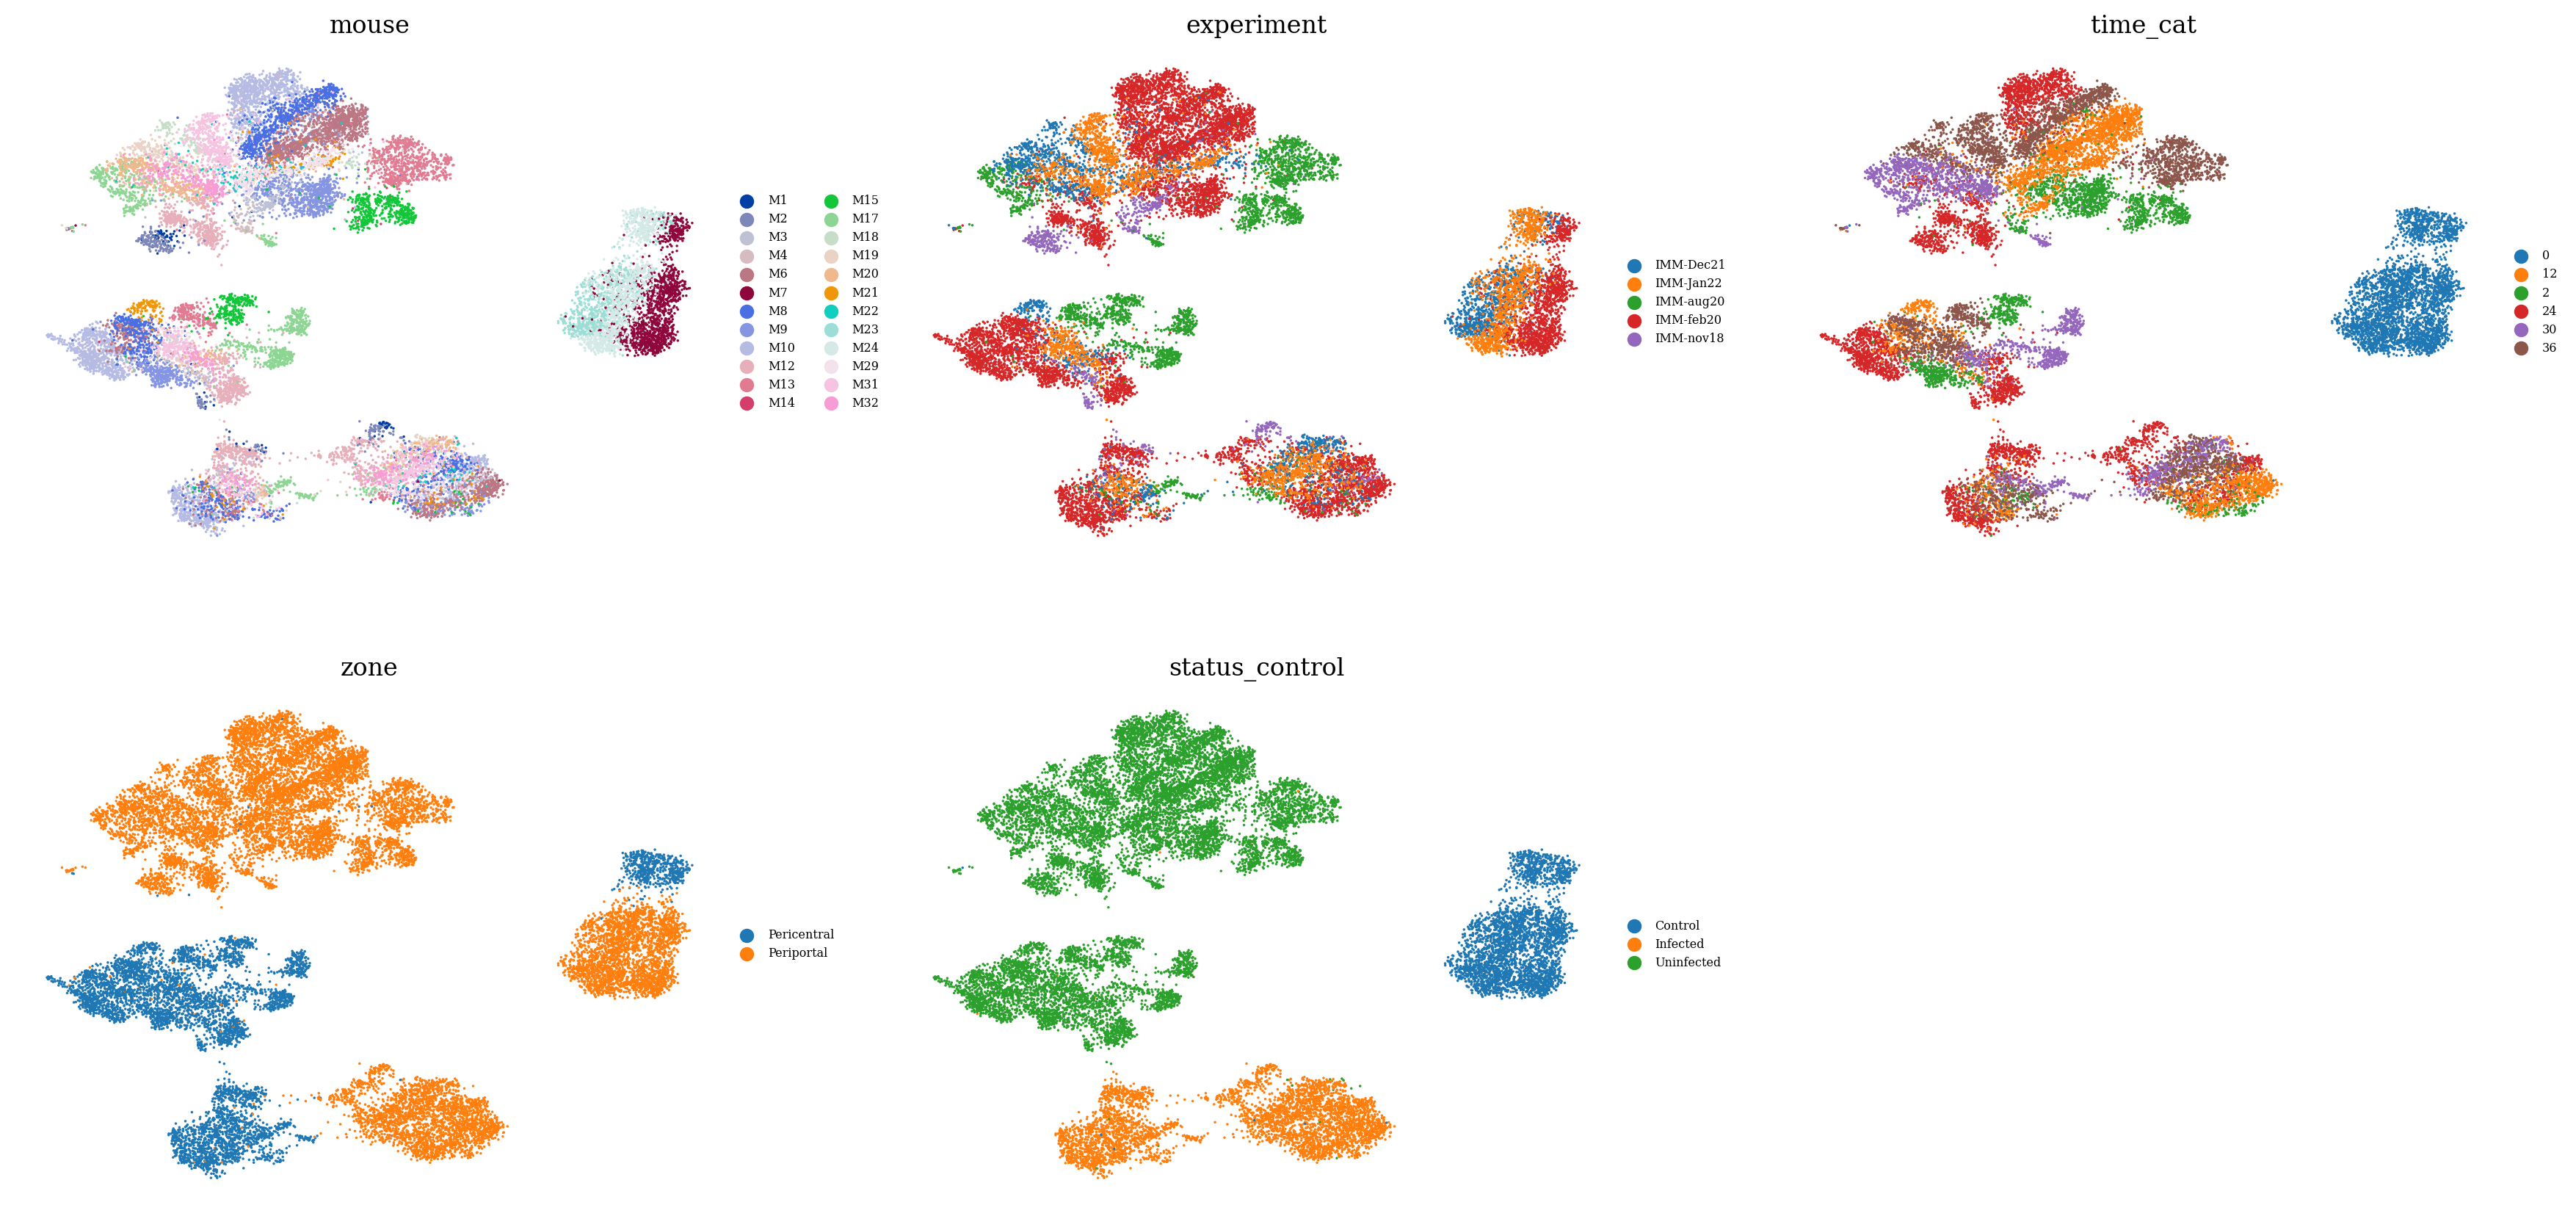

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

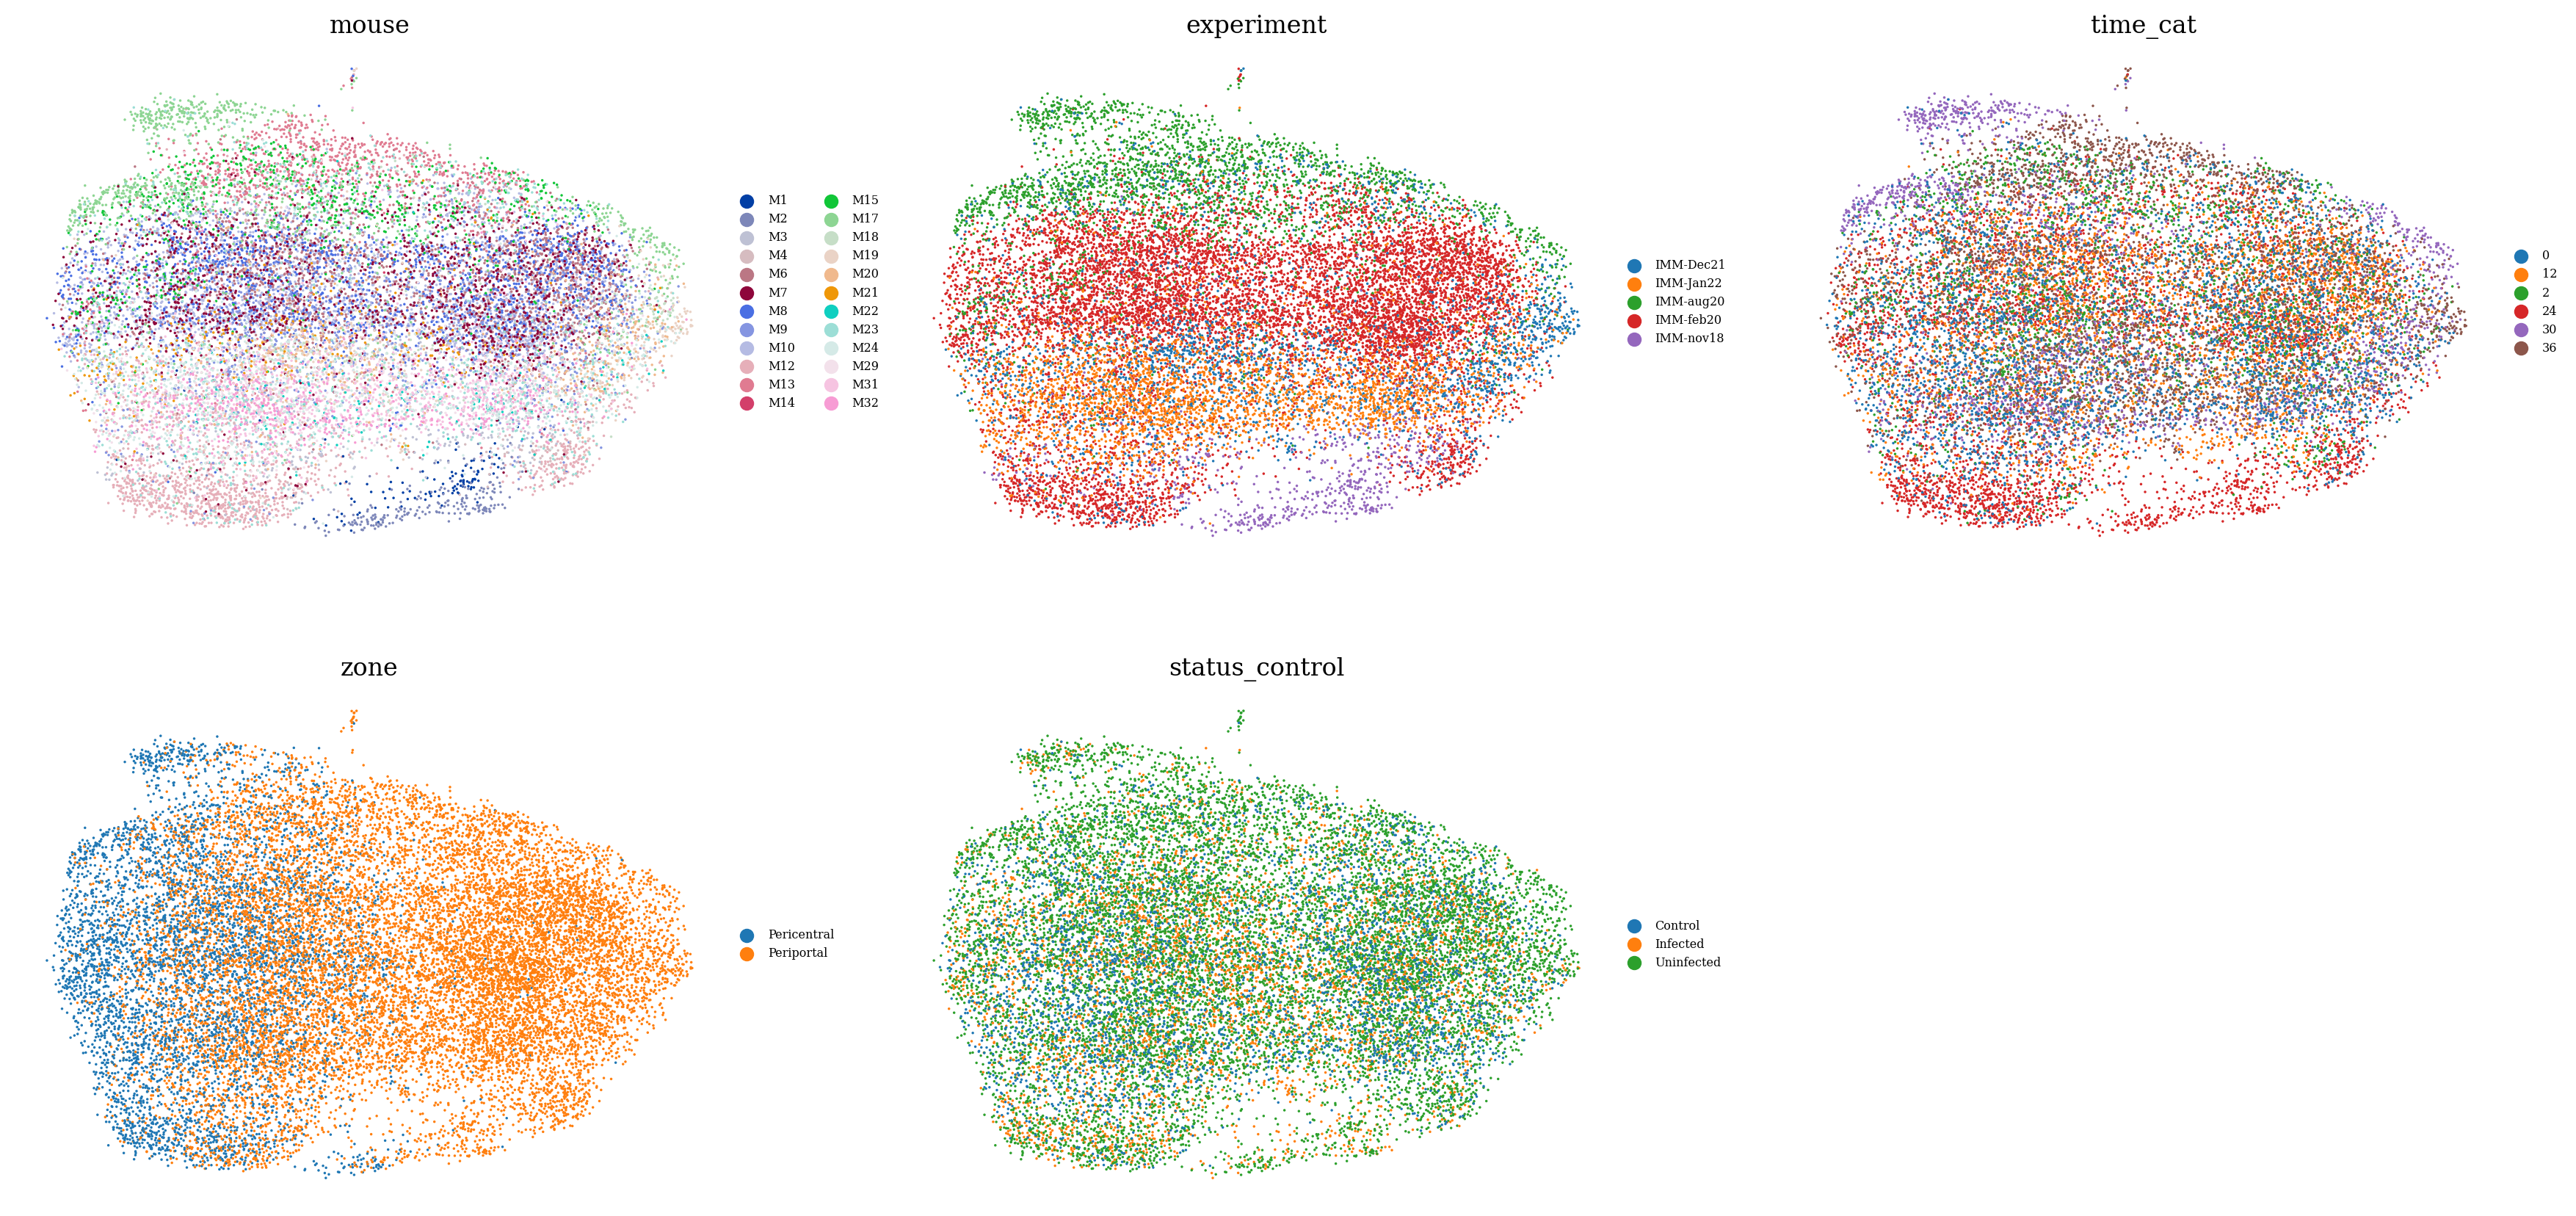

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▍         | 28/596 [00:00<00:02, 274.90it/s]

 10%|▉         | 57/596 [00:00<00:01, 279.47it/s]

 15%|█▍        | 87/596 [00:00<00:01, 288.13it/s]

 20%|█▉        | 118/596 [00:00<00:01, 293.89it/s]

 25%|██▌       | 149/596 [00:00<00:01, 297.21it/s]

 30%|███       | 180/596 [00:00<00:01, 299.49it/s]

 35%|███▌      | 211/596 [00:00<00:01, 300.93it/s]

 41%|████      | 242/596 [00:00<00:01, 301.62it/s]

 46%|████▌     | 273/596 [00:00<00:01, 301.61it/s]

 51%|█████     | 304/596 [00:01<00:00, 302.19it/s]

 56%|█████▌    | 335/596 [00:01<00:00, 301.97it/s]

 61%|██████▏   | 366/596 [00:01<00:00, 302.20it/s]

 67%|██████▋   | 397/596 [00:01<00:00, 302.13it/s]

 72%|███████▏  | 428/596 [00:01<00:00, 302.12it/s]

 77%|███████▋  | 459/596 [00:01<00:00, 302.59it/s]

 82%|████████▏ | 490/596 [00:01<00:00, 302.96it/s]

 87%|████████▋ | 521/596 [00:01<00:00, 303.19it/s]

 93%|█████████▎| 552/596 [00:01<00:00, 303.40it/s]

 98%|█████████▊| 583/596 [00:01<00:00, 303.56it/s]

100%|██████████| 596/596 [00:01<00:00, 300.02it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

In [23]:
np.mean(r2s)

0.9794320547607612

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)